In [28]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt

from embedding import load_emb_vectors, build_emb_weight
from loadData import create_dataset_obj, collate_func
from model import create_emb_layer, two_stage_RNN, test_model
from preprocess import tokenize_dataset, all_tokens_list, build_vocab, token2index_dataset 
from importlib import reload
# reload(loadData)
# from loadData import create_dataset_obj, collate_func

RANDOM_STATE = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Get pre-trained embeddings

In [28]:
# # encode the pretrained embedding to text file
# model = KeyedVectors.load_word2vec_format('/home/hb1500/Plated/vocab.bin', binary=True)
# model.save_word2vec_format('pretrained_embd.txt', binary=False)

In [4]:
# fname = '../../data/glove.6B.50d.txt'
# words_emb_dict = load_emb_vectors(fname)
words_emb_dict = {'a': np.zeros(50)}

### Load Cleaned Data 

In [5]:
steps = ['step_one','step_two', 'step_three', 'step_four', 'step_five', 'step_six']
steps_aug = ['step_one_sp', 'step_two_sp', 'step_three_sp',
             'step_four_sp', 'step_five_sp', 'step_six_sp']
tags = ['tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
        'tag_cuisine_asian', 'tag_cuisine_mexican',
        'tag_cuisine_latin-american', 'tag_cuisine_french',
        'tag_cuisine_italian', 'tag_cuisine_african',
        'tag_cuisine_mediterranean', 'tag_cuisine_american',
        'tag_cuisine_middle-eastern']

In [6]:
data_with_aug = pd.read_csv('../data/recipe_data_with_aug.csv', index_col=0)

In [7]:
data_with_aug_tags = data_with_aug[steps+steps_aug+tags]

In [8]:
print(data_with_aug_tags.columns)

Index(['step_one', 'step_two', 'step_three', 'step_four', 'step_five',
       'step_six', 'step_one_sp', 'step_two_sp', 'step_three_sp',
       'step_four_sp', 'step_five_sp', 'step_six_sp', 'tag_cuisine_indian',
       'tag_cuisine_nordic', 'tag_cuisine_european', 'tag_cuisine_asian',
       'tag_cuisine_mexican', 'tag_cuisine_latin-american',
       'tag_cuisine_french', 'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern'],
      dtype='object')


### Tokenization

In [9]:
print('Processing original instruction data')
# tokenize each steps on original datasets
steps_token = []
for step in steps:
    steps_token.append(step+'_token')
    data_with_aug_tags[step+'_token'] = tokenize_dataset(data_with_aug_tags[step])
    print(step, 'has been tokenized.')

# tokenize each steps on augmented datasets
print('Processing augmented instruction data')
steps_aug_token = []
for step in steps_aug:
    steps_aug_token.append(step+'_token')
    data_with_aug_tags[step+'_token'] = tokenize_dataset(data_with_aug_tags[step])
    print(step, 'has been tokenized.')

Processing original instruction data


/Users/xiangtingyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


step_one has been tokenized.
step_two has been tokenized.
step_three has been tokenized.
step_four has been tokenized.
step_five has been tokenized.
step_six has been tokenized.
Processing augmented instruction data


/Users/xiangtingyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


step_one_sp has been tokenized.
step_two_sp has been tokenized.
step_three_sp has been tokenized.
step_four_sp has been tokenized.
step_five_sp has been tokenized.
step_six_sp has been tokenized.


In [10]:
data_with_aug_tags = data_with_aug_tags[steps_token+steps_aug_token+tags]

In [11]:
data_with_aug_tags.columns

Index(['step_one_token', 'step_two_token', 'step_three_token',
       'step_four_token', 'step_five_token', 'step_six_token',
       'step_one_sp_token', 'step_two_sp_token', 'step_three_sp_token',
       'step_four_sp_token', 'step_five_sp_token', 'step_six_sp_token',
       'tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
       'tag_cuisine_asian', 'tag_cuisine_mexican',
       'tag_cuisine_latin-american', 'tag_cuisine_french',
       'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern'],
      dtype='object')

# Split train and test sets

In [12]:
train_val_data, test_data = train_test_split(data_with_aug_tags, test_size=0.1, random_state=RANDOM_STATE)
test_data = test_data[steps_token+tags]
#train_data, val_data, train_tags, val_tags = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

In [13]:
aug2ori_colname = dict(zip(steps_aug_token+tags, steps_token+tags))

Cross validation for train and validation 

In [14]:
tags_predicted = ['tag_cuisine_american']

test_targets = []
for row in test_data[tags_predicted].iterrows():
    test_targets.append(list(row[1].values))

In [24]:
rnn_types = {
    'rnn': nn.RNN,
    'lstm': nn.LSTM,
    'gru': nn.GRU
}

params = dict(
    rnn1_type = 'gru',
    rnn2_type = 'gru',
    bi = True,
    tags_predicted = tags_predicted,
    
    hidden_dim1 = 30,
    hidden_dim2 = 30,
    num_classes = 1,
    
    multi_task_train = None, #{'mean_loss', 'random_selection'}
    num_epochs = 10,
    batch_size = 50,
    learning_rate = 0.01,
    step_max_descent = 3,
    
    add_data_aug = True,
    cuda_on = True
    )

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
k = 1 
val_auc_kf = []
for train_index, val_index in kf.split(train_val_data):
    print('===================== This is the Kfold {} ====================='.format(k))
    k += 1
    val_data = train_val_data[steps_token+tags].iloc[val_index]
    train_data = train_val_data.iloc[train_index]
    
    if params['add_data_aug']:
        ##### add augmentation to training set by index #####
        train_org = train_data[steps_token+tags]
        train_aug = train_data[steps_aug_token+tags]
        train_aug.rename(index=str, columns=aug2ori_colname, inplace=True)
        train_data = pd.concat([train_org, train_aug], axis=0, ignore_index=False)
        ##### add augmentation to training set by index #####
    else:
        train_data = train_data[steps_token+tags]
    
    train_targets = []
    for row in train_data[tags_predicted].iterrows():
        train_targets.append(list(row[1].values))
    val_targets = []
    for row in val_data[tags_predicted].iterrows():
        val_targets.append(list(row[1].values))
    
    train_X = train_data[steps_token]
    val_X = val_data[steps_token]
    test_X = test_data[steps_token]
    all_train_tokens = all_tokens_list(train_X)
    max_vocab_size = len(list(set(all_train_tokens)))
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    emb_weight = build_emb_weight(words_emb_dict, id2token)
    train_data_indices = token2index_dataset(train_X, token2id)
    val_data_indices = token2index_dataset(val_X, token2id)
    test_data_indices = token2index_dataset(test_X, token2id)

    # batchify datasets: 
    batch_size = params['batch_size']
    max_sent_len = np.array([94, 86, 87, 90, 98, 91])
    train_loader, val_loader, test_loader = create_dataset_obj(train_data_indices, val_data_indices,
                                                           test_data_indices, train_targets,
                                                           val_targets, test_targets,
                                                           batch_size, max_sent_len, 
                                                           collate_func)
    
    val_auc, val_acc = train_model(params, emb_weight, train_loader, val_loader, test_loader)
    val_auc_kf.append(val_auc)
 

===================== This is the Kfold 1 =====================


/Users/xiangtingyan/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


The number of train parameters 23071
1/10, Step:1/73, TrainLoss:0.698178, ValAUC:[0.49947161237483817] ValAcc:[0.754424778761062]
1/10, Step:11/73, TrainLoss:0.589456, ValAUC:[0.5] ValAcc:[0.754424778761062]
1/10, Step:21/73, TrainLoss:0.551705, ValAUC:[0.5] ValAcc:[0.754424778761062]
1/10, Step:31/73, TrainLoss:0.738154, ValAUC:[0.5] ValAcc:[0.754424778761062]
1/10, Step:41/73, TrainLoss:0.668641, ValAUC:[0.5] ValAcc:[0.754424778761062]
1/10, Step:51/73, TrainLoss:0.653770, ValAUC:[0.5] ValAcc:[0.754424778761062]
1/10, Step:61/73, TrainLoss:0.580003, ValAUC:[0.5] ValAcc:[0.754424778761062]
1/10, Step:71/73, TrainLoss:0.666417, ValAUC:[0.5] ValAcc:[0.754424778761062]
Epoch: [1/10], trainAUC: [0.5], trainAcc: [0.7191135734072022]
Epoch: [1/10], ValAUC: [0.5], ValAcc: [0.754424778761062]
2/10, Step:1/73, TrainLoss:0.575575, ValAUC:[0.5] ValAcc:[0.754424778761062]
2/10, Step:11/73, TrainLoss:0.595080, ValAUC:[0.5] ValAcc:[0.754424778761062]
2/10, Step:21/73, TrainLoss:0.557019, ValAUC:[0.

KeyboardInterrupt: 

In [19]:
#build model
def train_model(params, emb_weight, train_loader, val_loader, test_loader):
    tags_predicted = params['tags_predicted']
    num_tasks = len(tags_predicted)
    rnn1_type = params['rnn1_type'] 
    rnn_1 = rnn_types[rnn1_type]
    rnn2_type = params['rnn2_type']
    rnn_2 = rnn_types[rnn2_type]
    bi = params['bi']
    hidden_dim1 = params['hidden_dim1']
    hidden_dim2 = params['hidden_dim2']
    
    multi_task_train = params['multi_task_train'] 
    num_classes = params['num_classes']
    batch_size = params['batch_size']
    cuda_on = params['cuda_on']

    weights_matrix = torch.from_numpy(emb_weight)
    model = two_stage_RNN(rnn_1, hidden_dim1, bi, rnn_2, hidden_dim2, batch_size, 
                          cuda_on, weights_matrix, num_tasks, num_classes)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print('The number of train parameters', sum([np.prod(p.size()) for p in model_parameters]))
    model = model.to(device)

    #parameter for training
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs'] # number epoch to train

    # Criterion and Optimizer
    #pos_weight=torch.Tensor([40,]).cuda()
    criterion = nn.BCEWithLogitsLoss() #torch.nn.BCELoss(); torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_list = []

    for epoch in range(num_epochs):
        for i, (steps_batch, lengths_batch, labels_batch) in enumerate(train_loader):
            for step_id in range(6):
                lengths_batch[step_id] = lengths_batch[step_id].to(device)
                steps_batch[step_id] = steps_batch[step_id].to(device)
            model.train()
            optimizer.zero_grad()
            logits = model(steps_batch, lengths_batch)
            if num_tasks == 1:
                task_id = 0
            else:
                print('Task number is greater than 1')
            loss = criterion(logits[task_id], labels_batch[task_id].view(-1,1).float().to(device))
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i % 10 == 0:
                # validate
#                 print('---------------------')
#                 for p in model.parameters():
#                     if p.requires_grad:
#                         print(p.name, p.size(), p.requires_grad, torch.mean(torch.abs(p.data)), torch.mean(torch.abs(p.grad)))
#                         break
                val_auc, val_acc = test_model(val_loader, model)
                print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValAUC:{} ValAcc:{}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), loss, val_auc, val_acc))
        val_auc, val_acc = test_model(val_loader, model)
        train_auc, train_acc = test_model(train_loader, model)
        print('Epoch: [{}/{}], trainAUC: {}, trainAcc: {}'.format(epoch+1, num_epochs, train_auc, train_acc))
        print('Epoch: [{}/{}], ValAUC: {}, ValAcc: {}'.format(epoch+1, num_epochs, val_auc, val_acc))


In [23]:
data_cuisine_tags.iloc[:,1:].sum()/data_cuisine_tags.iloc[:,1:].shape[0]

tag_cuisine_indian            0.023525
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896
tag_cuisine_french            0.077352
tag_cuisine_italian           0.233254
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555
tag_cuisine_american          0.273525
tag_cuisine_middle-eastern    0.046252
dtype: float64

Choose tag: tag_cuisine_american, which 27.3525% are 1 

Reconstruct data strcuture for datasets

tag_cuisine_indian            0.023525  85% auc
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217  98% auc
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896  90% auc
tag_cuisine_french            0.077352  72% auc
tag_cuisine_italian           0.233254  80% auc
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555  88% auc
tag_cuisine_american          0.273525  80% auc
tag_cuisine_middle-eastern    0.046252  87% auc

In [242]:
# test model
logits_all = []
labels_all = []
model.eval()
for steps_batch, lengths_batch, labels_batch in test_loader:
    for step_id in range(6):
        lengths_batch[step_id] = lengths_batch[step_id].to(device)
        steps_batch[step_id] = steps_batch[step_id].to(devi) 
    logits = model(steps_batch, lengths_batch)
    logits_all.extend(list(logits.cpu().detach().numpy()))
    labels_all.extend(list(labels_batch.numpy()))
logits_all = np.array(logits_all)
labels_all = np.array(labels_all)
auc = roc_auc_score(labels_all, logits_all)
predicts = (logits_all > 0.5).astype(int)
acc = np.mean(predicts==labels_all)

In [243]:
auc

0.82168113146898103

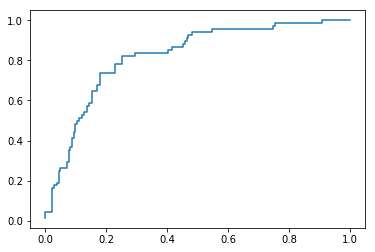

In [244]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_all, logits_all, pos_label=1)
plt.plot(fpr, tpr)